# Introduction

## Project Overview

### Objective

<b>Build a binary classification model that predicts the "Charged Off" or "Fully Paid" Status of a loan, and explain what features are the best predictors.   The purpose is to use this model would be used to place trades on loans immediately after they are issued by Lending Club.</b>

### Summary

Data used for this project comes directly from Lending Club’s historical loan records (the full record contains more than 100 columns).

## Project Setup

### Import Libraries & Modules

In [41]:
import pandas as pd
import numpy as np

import ipympl
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import pandas_profiling

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import LabelBinarizer, Imputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score

# written by Gilles Louppe and distributed under the BSD 3 clause
from blagging import BlaggingClassifier

# self-authored library that to facilatate ML classification and evaluation
from skhelper import LearningModel, eval_db

### Custom Functions

### Notebook Config

In [2]:
from IPython.display import display
from IPython.core.display import HTML
from jupyterthemes import jtplot
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.width = 80
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
%matplotlib inline
%config InlineBackend.figure_format='retina'
#%config InlineBackend.figsize=(18,12)
# currently installed theme will be used to
# set plot style if no arguments provided
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
jtplot.style(theme='monokai', figsize=(12, 8), context='notebook')

In [4]:
HTML(open("custom_nb.css", "r").read())
#matplotlib.style.use('ggplot')
#HTML(open("custom_nb.js", "r").read())

# Data Preprocessing

## Load Dataset

In [5]:
def load_dataset(path='data/lc_historical.csv'):
    lc = pd.read_csv(path, index_col='id', memory_map=True, low_memory=False)
    lc.loan_status = pd.Categorical(lc.loan_status, categories=['Fully Paid', 'Charged Off'])
    return lc

In [6]:
dataset = load_dataset()

## Exploration

### Summary

- <b>Target:</b> loan-status
- <b>Number of features:</b> 18 
- <b>Number of observations:</b> 138196 
- <b>Feature datatypes:</b> 
     + object: dti, bc_util, fico_range_low, percent_bc_gt_75, acc_open_past_24mths, annual_inc, recoveries, avg_cur_bal, loan_amnt
     + <i>float64</i>: revol_util, earliest_cr_line, purpose, emp_length, home_ownership, addr_state, issue_d, loan_status
- <b>Features with ALL missing or null values:</b>
     + inq_last_12m
     + all_util
- <b>Features with SOME missing or null values:</b>
     + avg_cur_bal (30%) 
     + bc_util (21%) 
     + percent_bc_gt_75 (21%) 
     + acc_open_past_24mths (20%) 
     + emp_length (0.18%) 
     + revol_util (0.08%) 

### Missing Data

In [7]:
def calc_incomplete_stats(dataset):
    warnings.filterwarnings("ignore", 'This pattern has match groups')
    missing_data = pd.DataFrame(index=dataset.columns)
    missing_data['Null'] = dataset.isnull().sum()
    missing_data['NA_or_Missing'] = (
        dataset.apply(lambda col: (
            col.str.contains('(^$|n/a|^na$|^%$)', case=False).sum()))
        .fillna(0).astype(int))
    missing_data['Incomplete'] = (
        (missing_data.Null + missing_data.NA_or_Missing) / len(dataset))
    incomplete_stats = ((missing_data[(missing_data > 0).any(axis=1)])
                        .sort_values('Incomplete', ascending=False))
    return incomplete_stats

def display_incomplete_stats(incomplete_stats):
    stats = incomplete_stats.copy()
    df_incomplete = (
        stats.style
        .set_caption('Missing')
        .background_gradient(cmap=sns.light_palette("orange", as_cmap=True),
                             low=0, high=1, subset=['Null', 'NA_or_Missing'])
        .background_gradient(cmap=sns.light_palette("red", as_cmap=True),
                             low=0, high=.6, subset=['Incomplete'])
        .format({'Null': '{:,}', 'NA_or_Missing': '{:,}', 'Incomplete': '{:.1%}'}))
    display(df_incomplete)
    
def plot_incomplete_stats(incomplete_stats, ylim_range=(0, 100)):
    stats = incomplete_stats.copy()
    stats.Incomplete = stats.Incomplete * 100
    _ = sns.barplot(x=stats.index.tolist(), y=stats.Incomplete.tolist())
    for item in _.get_xticklabels():
        item.set_rotation(45)
    _.set(xlabel='Feature', ylabel='Incomplete (%)', 
          title='Features with Missing or Null Values',
          ylim=ylim_range)
    plt.show()
    
def incomplete_data_report(dataset, display_stats=True, plot=True):
    incomplete_stats = calc_incomplete_stats(dataset)
    if display_stats:
        display_incomplete_stats(incomplete_stats)
    if plot:
        plot_incomplete_stats(incomplete_stats)


incomplete_stats = load_dataset().pipe(calc_incomplete_stats)
display(incomplete_stats)

,Null,NA_or_Missing,Incomplete
all_util,172745,0,1.000000
inq_last_12m,172745,0,1.000000
avg_cur_bal,51649,0,0.298990
bc_util,36407,0,0.210756
percent_bc_gt_75,36346,0,0.210403
acc_open_past_24mths,35121,0,0.203311
emp_length,0,7507,0.043457
revol_util,144,0,0.000834


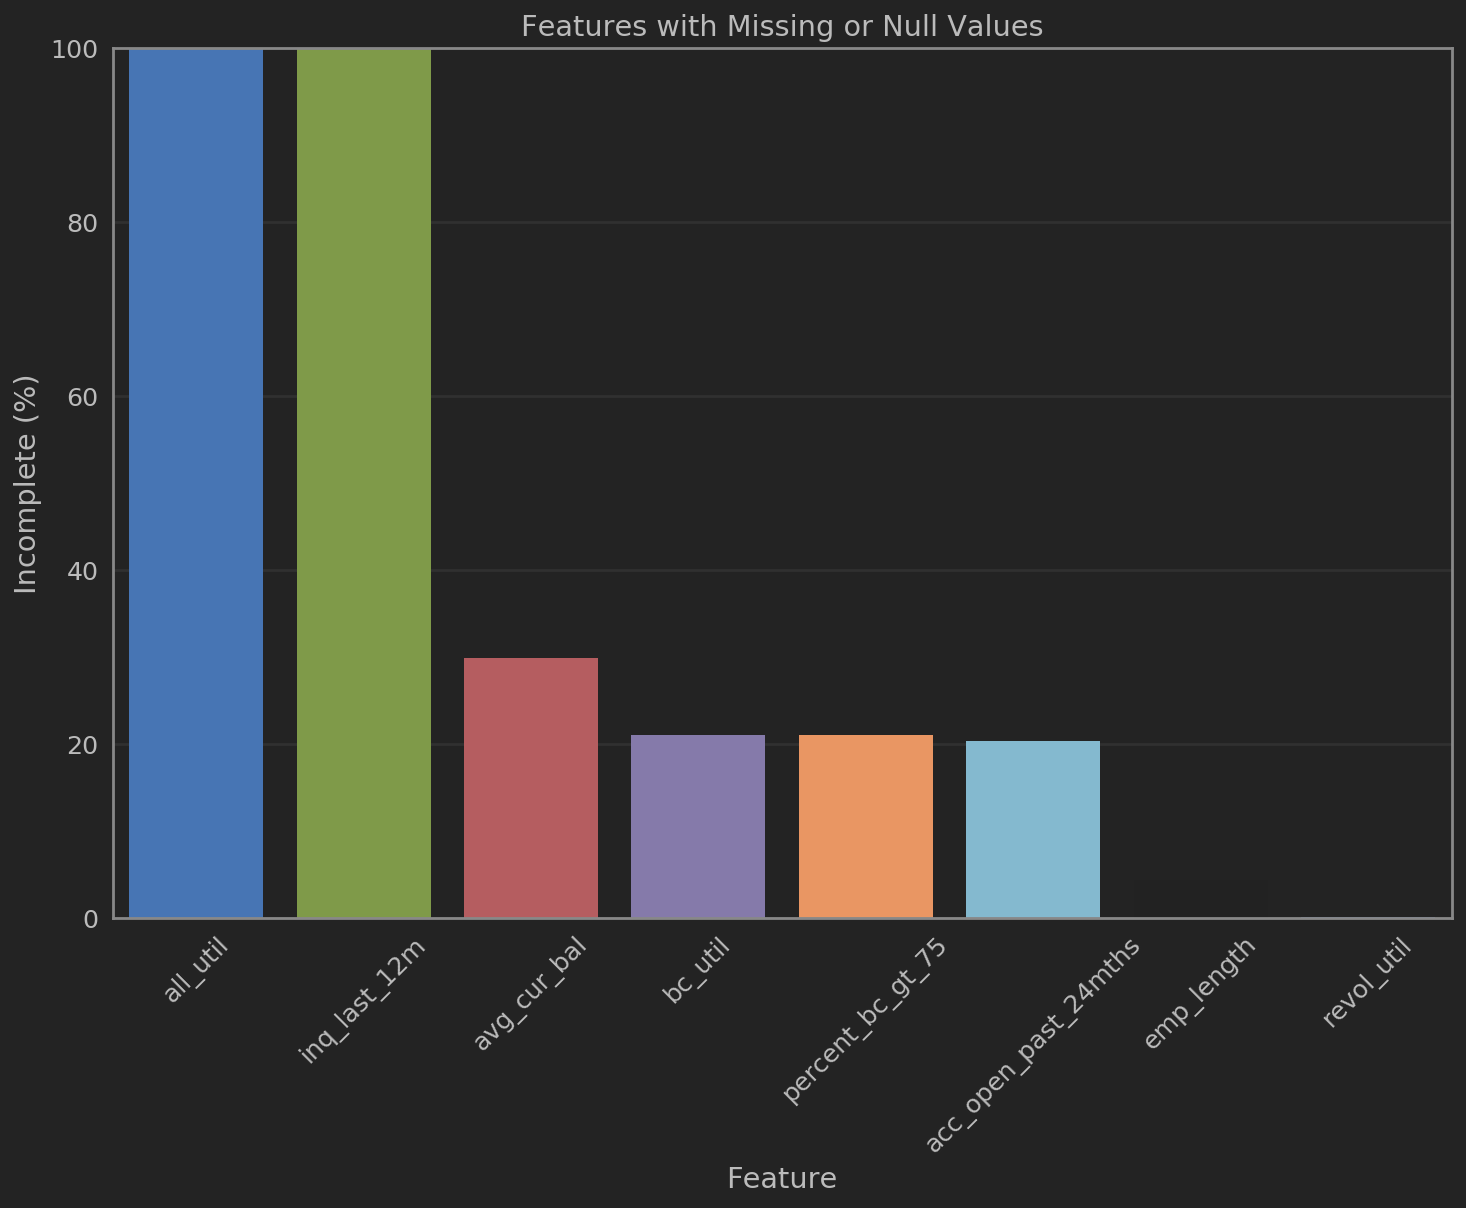

In [8]:
plot_incomplete_stats(incomplete_stats)

## Data Munging

### Cleaning

- all_util, inq_last_12m
    + Drop features (all observations contain null/missing values)
- revol_util
    1. Remove the percent sign (%) from string
    2. Convert to a float
- earliest_cr_line, issue_d
    + Convert to datetime data type.
- emp_length
    1. Strip leading and trailing whitespace
    2. Replace '< 1' with '0.5'
    3. Replace '10+' with '10.5'
    4. Fill null values with '-1.5'
    5. Convert to float

In [9]:
def clean_data(lc):
    lc = lc.copy().dropna(axis=1, thresh=1)
    
    dt_features = ['earliest_cr_line', 'issue_d']
    lc[dt_features] = lc[dt_features].apply(
        lambda col: pd.to_datetime(col, format='%Y-%m-%d'), axis=0)
    
    cat_features =['purpose', 'home_ownership', 'addr_state']
    lc[cat_features] = lc[cat_features].apply(pd.Categorical, axis=0)
    
    lc.revol_util = (lc.revol_util
                     .str.extract('(\d+\.?\d?)', expand=False)
                     .astype('float'))
    
    lc.emp_length = (lc.emp_length
                     .str.extract('(< 1|10\+|\d+)', expand=False)
                     .replace('< 1', '0.5')
                     .replace('10+', '10.5')
                     .fillna('-1.5')
                     .astype('float'))
    return lc

In [10]:
dataset = load_dataset().pipe(clean_data)

## Feature Engineering

### New Features

- loan_amnt_to_inc
    + the ratio of loan amount to annual income
- earliest_cr_line_age
    + age of first credit line from when the loan was issued
- avg_cur_bal_to_inc
    + the ratio of avg current balance to annual income
- avg_cur_bal_to_loan_amnt
    + the ratio of avg current balance to loan amount
- acc_open_past_24mths_groups
    + level of accounts opened in the last 2 yrs

In [11]:
def add_features(lc):
    # ratio of loan amount to annual income
    group_labels = ['low', 'avg', 'high']
    lc['loan_amnt_to_inc'] = (
        pd.cut((lc.loan_amnt / lc.annual_inc), 3, labels=['low', 'avg', 'high'])
        .cat.set_categories(['low', 'avg', 'high'], ordered=True))
    
    # age of first credit line from when the loan was issued
    lc['earliest_cr_line_age'] = (lc.issue_d - lc.earliest_cr_line).astype(int)
    
    # the ratio of avg current balance to annual income
    lc['avg_cur_bal_to_inc'] = lc.avg_cur_bal / lc.annual_inc
    
    # the ratio of avg current balance to loan amount
    lc['avg_cur_bal_to_loan_amnt'] = lc.avg_cur_bal / lc.loan_amnt
    
    # grouping level of accounts opened in the last 2 yrs
    lc['acc_open_past_24mths_groups'] = (
        pd.qcut(lc.acc_open_past_24mths, 3, labels=['low', 'avg', 'high'])
        .cat.add_categories(['unknown']).fillna('unknown')
        .cat.set_categories(['low', 'avg', 'high', 'unknown'], ordered=True))
    
    return lc

In [12]:
dataset = load_dataset().pipe(clean_data).pipe(add_features)

### Drop Features

In [13]:
def drop_features(lc):
    target_leaks = ['recoveries', 'issue_d']
    other_features = ['earliest_cr_line', 'acc_open_past_24mths', 'addr_state']
    to_drop = target_leaks + other_features
    return lc.drop(to_drop, axis=1)

In [14]:
dataset = load_dataset().pipe(clean_data).pipe(add_features).pipe(drop_features)

## Load & Prepare Function

In [15]:
def load_prepare_dataset():
    return (load_dataset()
            .pipe(clean_data)
            .pipe(add_features)
            .pipe(drop_features))

# Exploratory Data Analysis (EDA)

In [16]:
def plot_factor_pct(dataset, feature):
    if feature not in dataset.columns:
        return
    y = dataset[feature]
    factor_counts = y.value_counts()
    x_vals = factor_counts.index.tolist()
    y_vals = ((factor_counts.values/factor_counts.values.sum())*100).round(2)
    sns.barplot(y=x_vals, x=y_vals);

def plot_pct_charged_off(lc, feature):
    lc_counts = lc[feature].value_counts()
    charged_off = lc[lc.loan_status=='Charged Off']
    charged_off_counts = charged_off[feature].value_counts()
    charged_off_ratio = ((charged_off_counts / lc_counts * 100)
                         .round(2).sort_values(ascending=False))

    x_vals = charged_off_ratio.index.tolist()
    y_vals = charged_off_ratio
    sns.barplot(y=x_vals, x=y_vals);

## Overview

In [43]:
pfr = (load_dataset()
 .pipe(clean_data)
 .pipe(add_features)
 .pipe(drop_features)
 .pipe(pandas_profiling.ProfileReport))
pfr.to_file("docs/eda.html")

### Missing Data

In [17]:
incomplete_stats = (load_dataset()
                    .pipe(clean_data)
                    .pipe(add_features)
                    .pipe(drop_features)
                    .pipe(calc_incomplete_stats))

display(incomplete_stats)

,Null,NA_or_Missing,Incomplete
avg_cur_bal,51649,0,0.298990
avg_cur_bal_to_inc,51649,0,0.298990
avg_cur_bal_to_loan_amnt,51649,0,0.298990
bc_util,36407,0,0.210756
percent_bc_gt_75,36346,0,0.210403
revol_util,144,0,0.000834


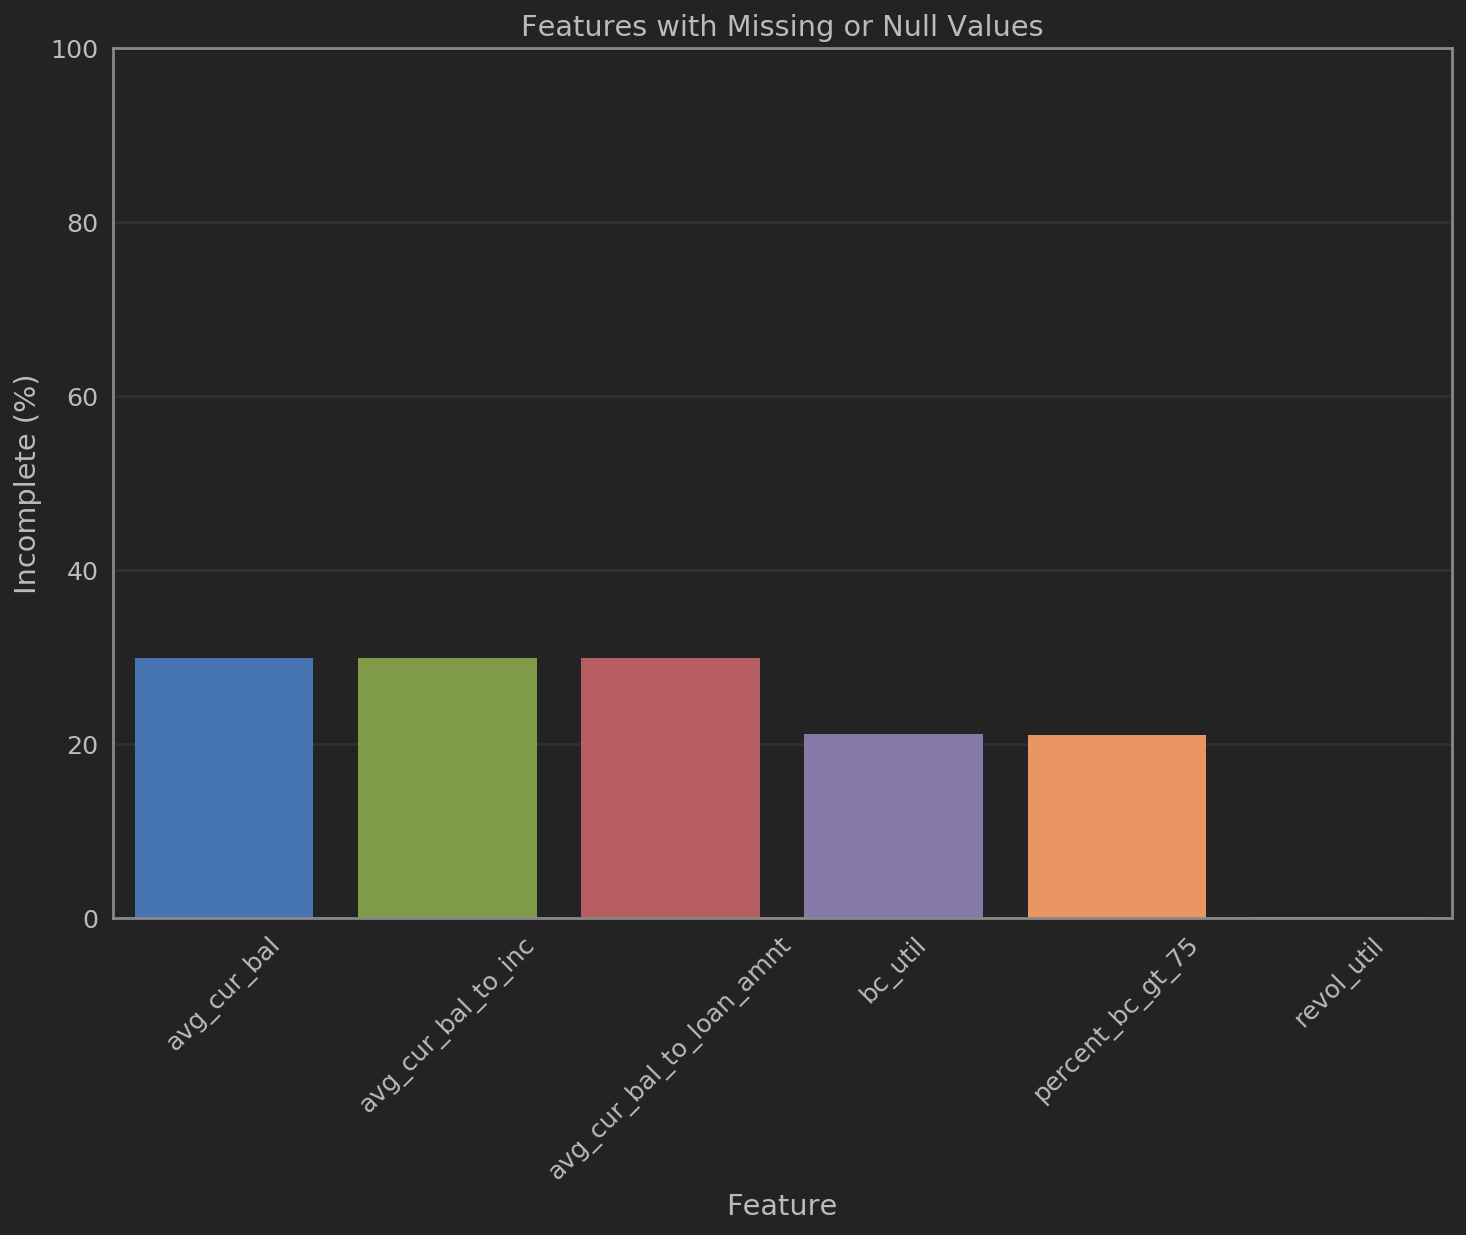

In [18]:
plot_incomplete_stats(incomplete_stats)

## Factor Analysis

### Target: loan_status

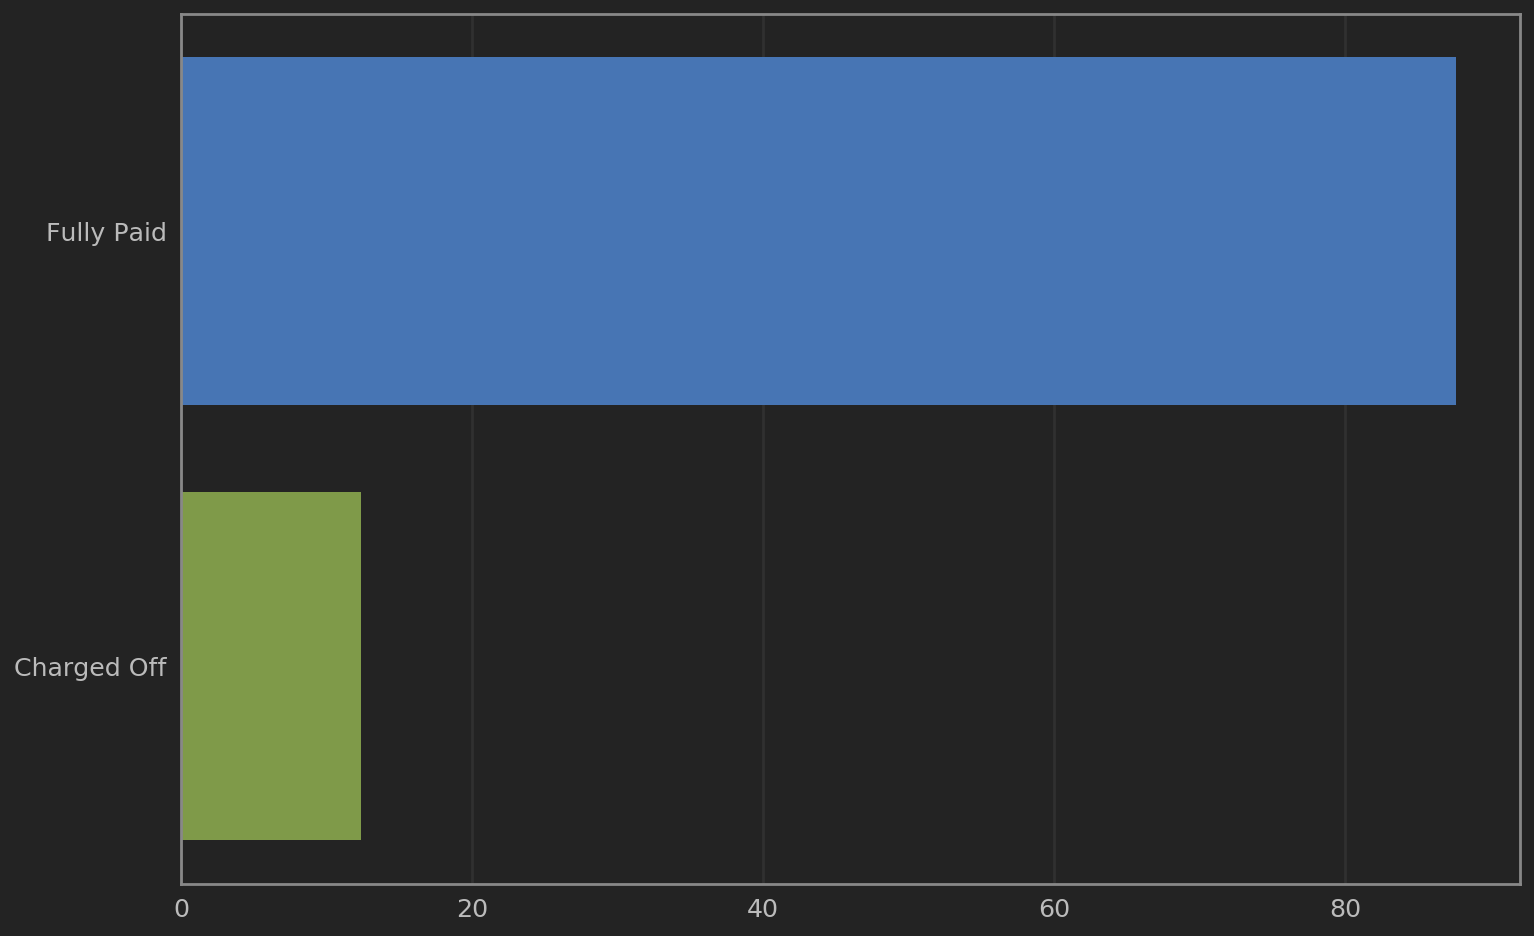

In [19]:
plot_factor_pct(dataset, 'loan_status')

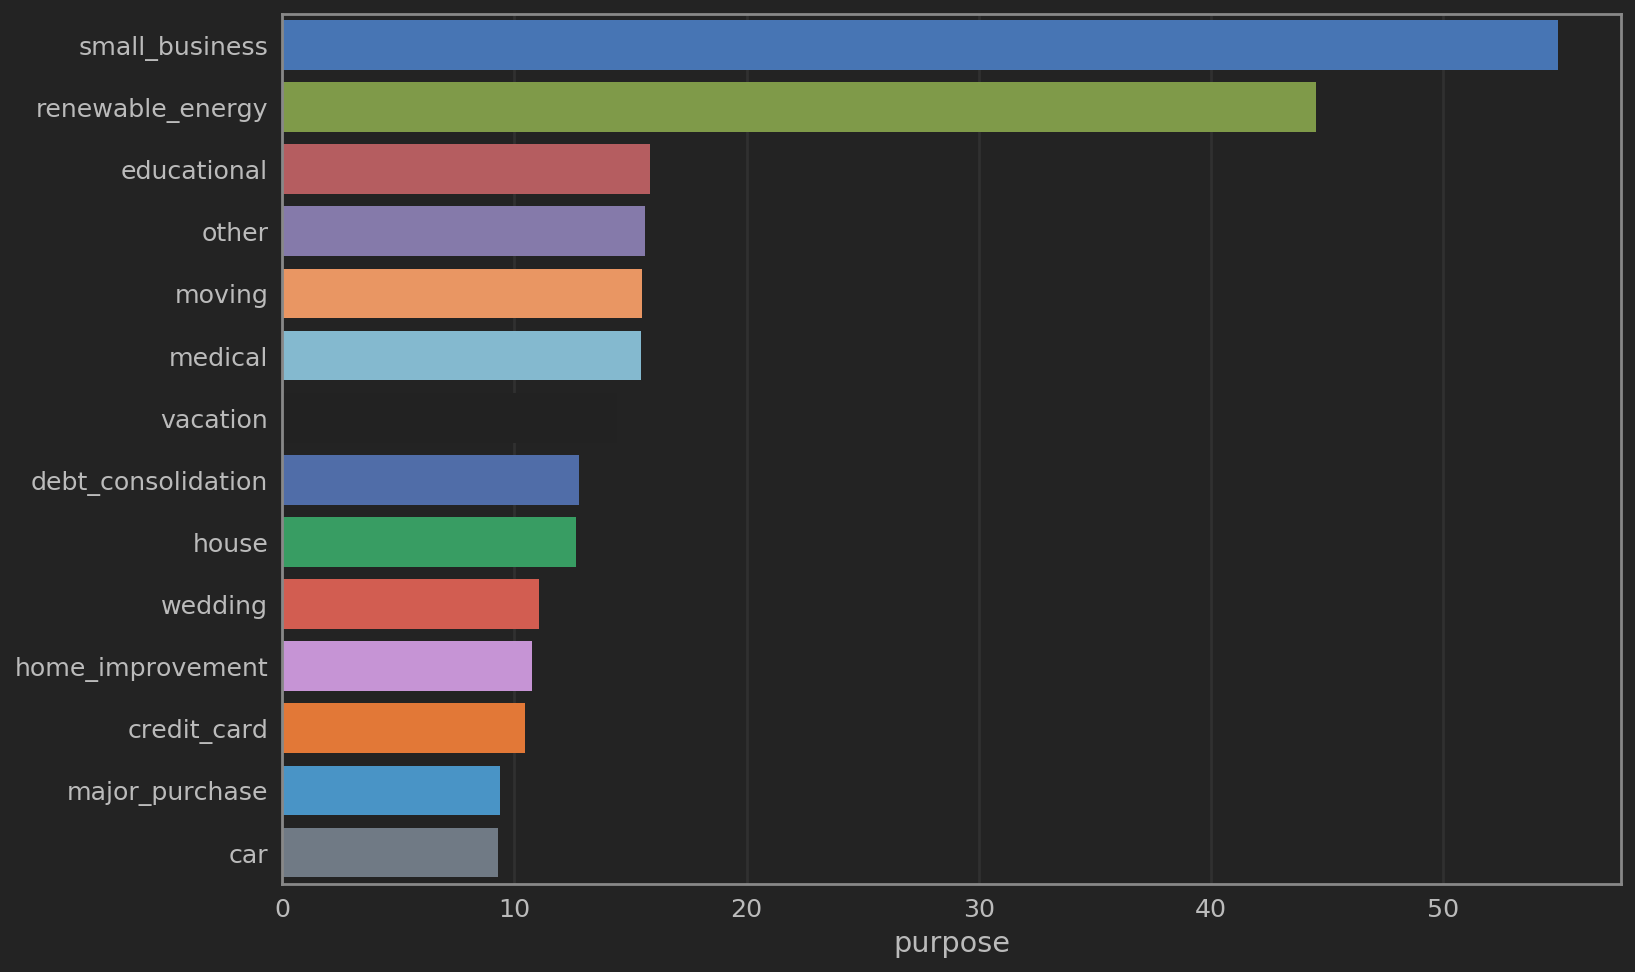

In [40]:
plot_factor_pct(dataset, 'home_ownership');

plot_pct_charged_off(dataset, 'home_ownership');

plot_factor_pct(dataset, 'purpose');

plot_pct_charged_off(dataset, 'purpose');

## Summary Statistics

# Predictive Modeling

In [24]:
def load_and_preprocess_data():
    return (load_dataset()
            .pipe(clean_data)
            .pipe(add_features)
            .pipe(drop_features))

def to_xy(dataset):
    y = dataset.pop('loan_status').cat.codes
    X = pd.get_dummies(dataset, drop_first=True)
    return X, y

## Initializing Train/Test Sets

### Shuffle and Split Data

Let's split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [25]:
X, y = load_and_preprocess_data().pipe(to_xy)
split_data = train_test_split(X, y, test_size=0.20, stratify=y, random_state=11)
X_train, X_test, y_train, y_test = split_data

dnames = ['X_train', 'X_test', 'y_train', 'y_test']
train_test_sets = dict(zip(dnames, [*split_data]))

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 138196 samples.
Testing set has 34549 samples.


## Classification Models

### Naive Predictor (Baseline)

In [26]:
dummy_pipe = Pipeline([('imp', Imputer(strategy='median')), 
                       ('clf', DummyClassifier(strategy='constant', constant=0))])

In [27]:
from sklearn.metrics import precision_score

dummy_pipe.fit(X_train, y_train)

#
naive_pred = dummy_pipe.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_pred=naive_pred, y_true=y_test)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}]".format(accuracy))

Naive Predictor: [Accuracy score: 0.8762]


### Decision Tree Classifier

,FitTime,Accuracy,FBeta,F1,AUC
Decision Tree Classifier,2.0,0.78558,0.156742,0.154531,0.516244


             precision    recall  f1-score   support

          0       0.88      0.87      0.88     30271
          1       0.15      0.16      0.15      4278

avg / total       0.79      0.79      0.79     34549



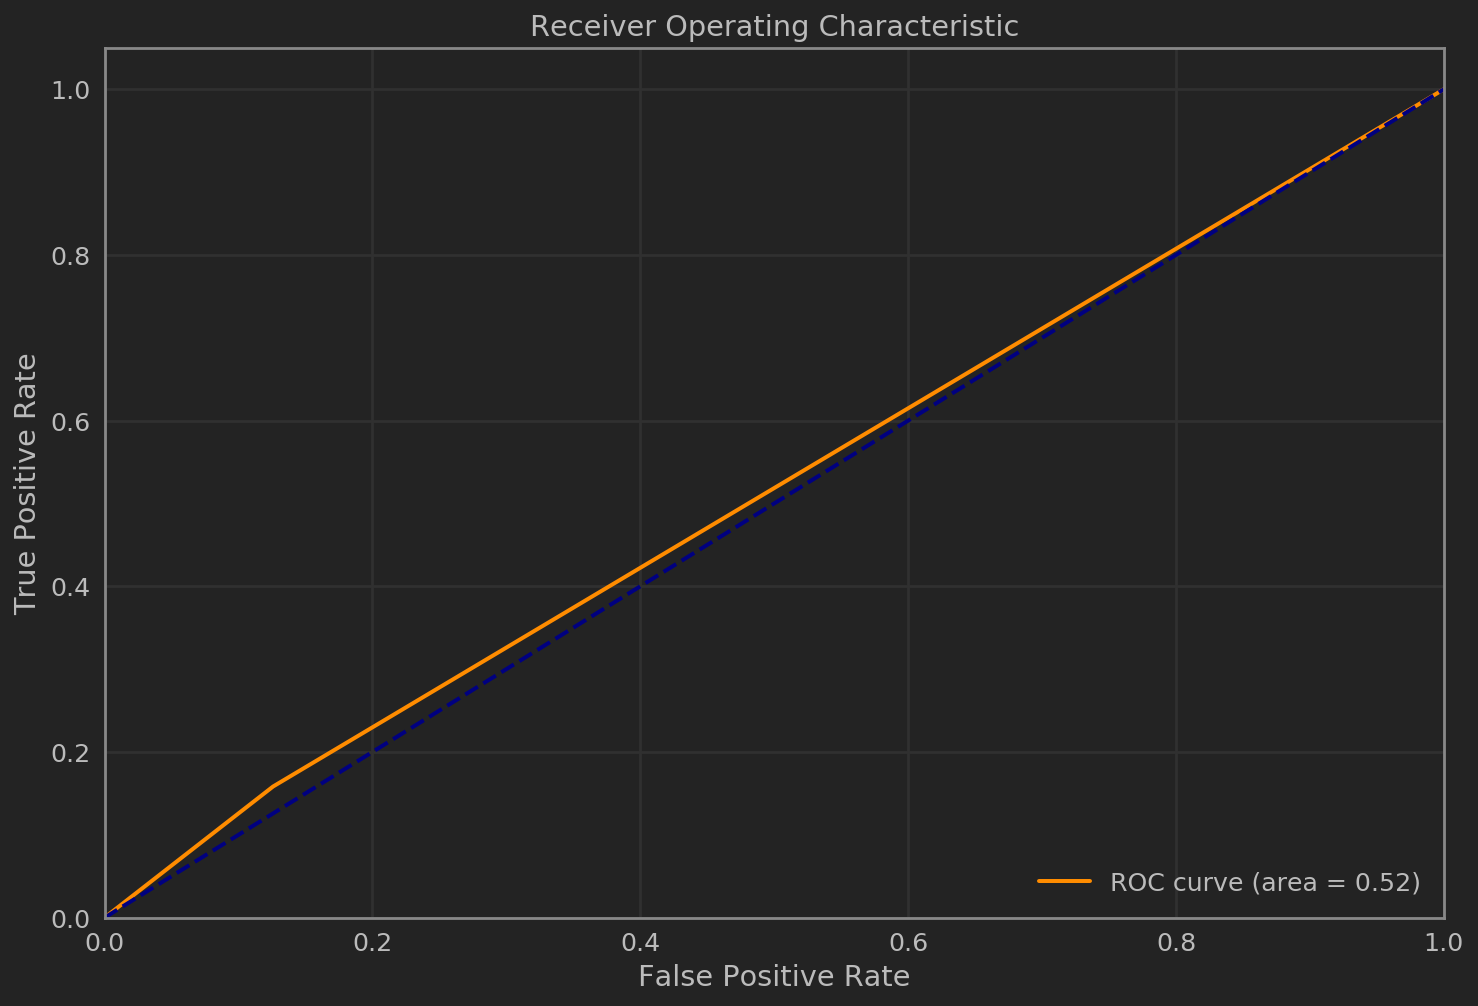

In [28]:
tree_clf = DecisionTreeClassifier(class_weight='balanced', random_state=11)
tree_pipeline = Pipeline([('imp', Imputer(strategy='median')), ('clf', tree_clf)])
tree_model = LearningModel('Decision Tree Classifier', tree_pipeline)
# notes='Baseline Model'

tree_model.fit_and_predict(**train_test_sets)
tree_model.display_evaluation()
model_evals = eval_db(tree_model.eval_report)

### Random Forest Classifier

,FitTime,Accuracy,FBeta,F1,AUC
Random Forest Classifier,2.0,0.874671,0.008998,0.014117,0.573608


             precision    recall  f1-score   support

          0       0.88      1.00      0.93     30271
          1       0.27      0.01      0.01      4278

avg / total       0.80      0.87      0.82     34549



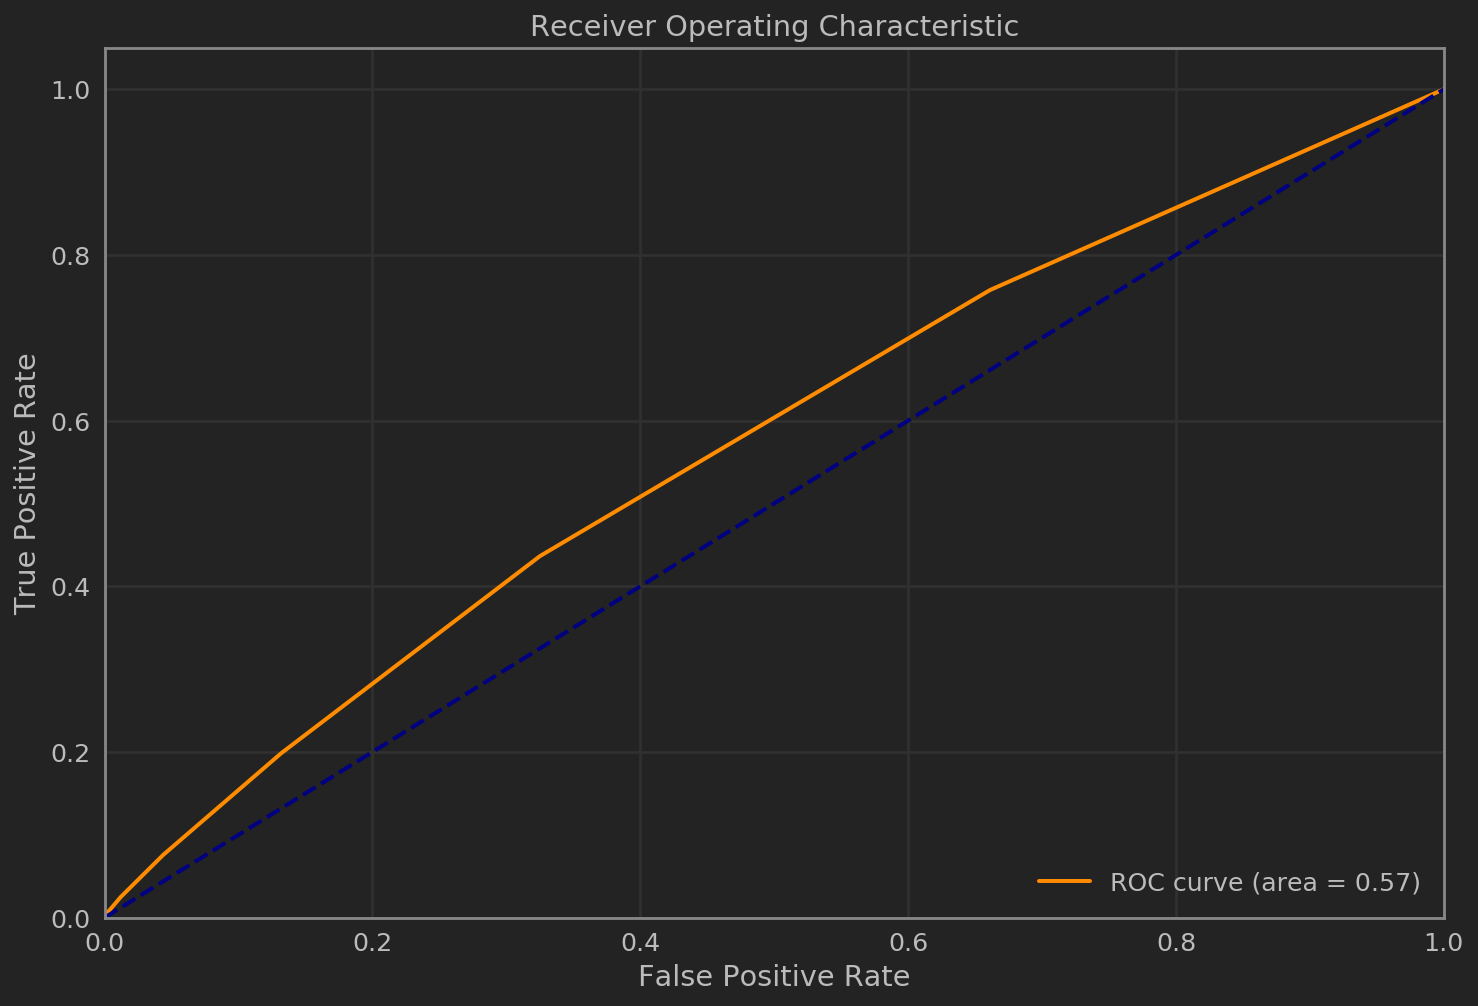

In [29]:
rf_clf_baseline = RandomForestClassifier(class_weight='balanced_subsample', 
                                         random_state=11)
rf_pipeline = Pipeline([('imp', Imputer(strategy='median')), 
                        ('clf', rf_clf_baseline)])

rf_model = LearningModel('Random Forest Classifier', rf_pipeline)
rf_model.fit_and_predict(**train_test_sets)
rf_model.display_evaluation()
model_evals = eval_db(model_evals, rf_model.eval_report)

### Blagging Classifier

#### Base Estimator -> RF

,FitTime,Accuracy,FBeta,F1,AUC
Blagging Classifier (RF),2.0,0.719181,0.344518,0.270746,0.645877


             precision    recall  f1-score   support

          0       0.90      0.76      0.83     30271
          1       0.20      0.42      0.27      4278

avg / total       0.82      0.72      0.76     34549



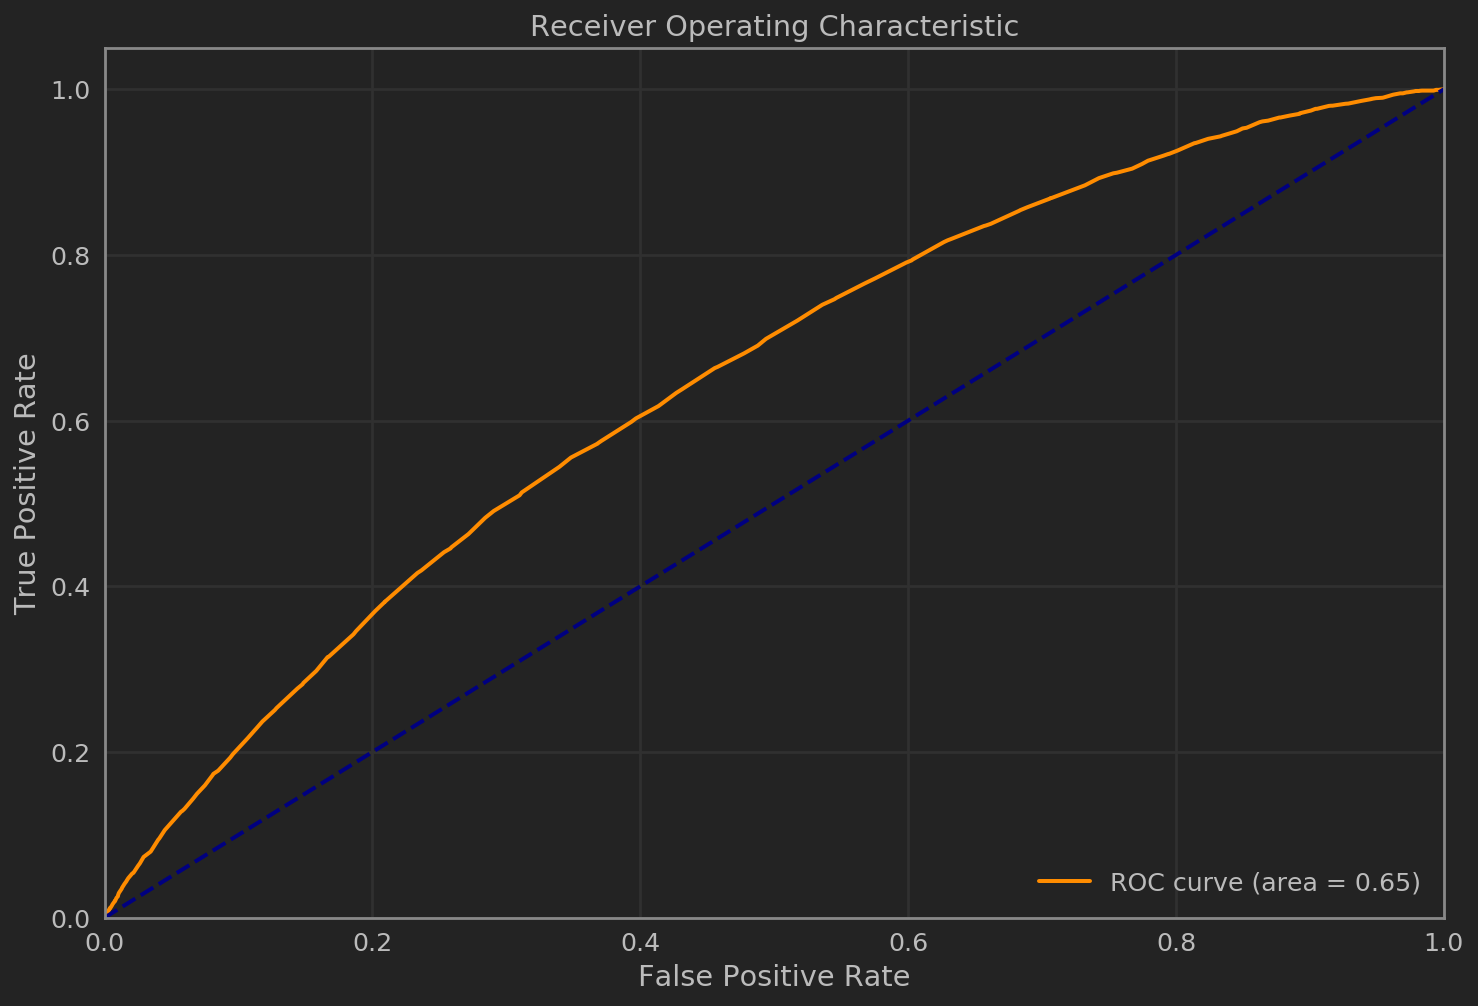

In [30]:
blagging_base = RandomForestClassifier(class_weight='balanced_subsample', 
                                       random_state=11)
blagging_clf = BlaggingClassifier(base_estimator=blagging_base, 
                                  random_state=11, n_jobs=-1)
blagging_pipeline = Pipeline([('imp', Imputer(strategy='median')), 
                              ('clf', blagging_clf)])

blagging_model = LearningModel('Blagging Classifier (RF)', blagging_pipeline)
blagging_model.fit_and_predict(**train_test_sets)
blagging_model.display_evaluation()
model_evals = eval_db(model_evals, blagging_model.eval_report)
# notes='Base Estimator=ExtraTrees'

#### Base Estimator -> ExtraTrees

,FitTime,Accuracy,FBeta,F1,AUC
Blagging Classifier (Extra Trees),20.0,0.749718,0.309224,0.259611,0.645899


             precision    recall  f1-score   support

          0       0.90      0.81      0.85     30271
          1       0.20      0.35      0.26      4278

avg / total       0.81      0.75      0.78     34549



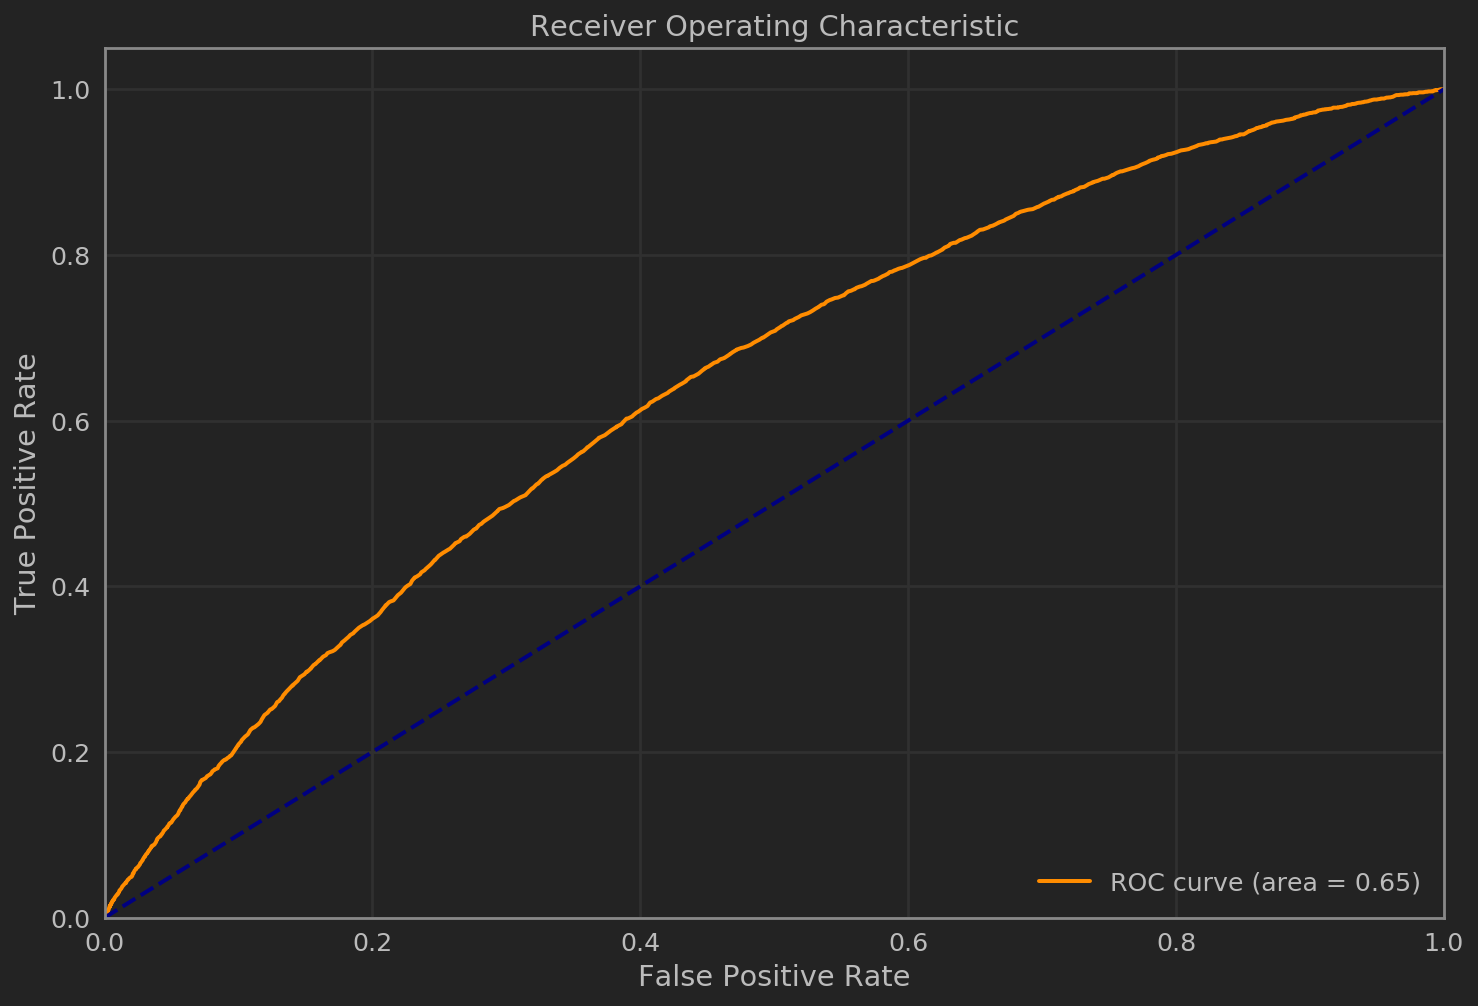

In [31]:
blagging_base = ExtraTreesClassifier(criterion='entropy', 
                                     class_weight='balanced_subsample', 
                                     max_features=None, 
                                     n_estimators=60, random_state=11)
blagging_clf = BlaggingClassifier(base_estimator=blagging_base, random_state=11, n_jobs=-1)
blagging_pipeline = Pipeline([('imp', Imputer(strategy='median')), 
                              ('clf', blagging_clf)])

blagging_model = LearningModel('Blagging Classifier (Extra Trees)', 
                               blagging_pipeline)
blagging_model.fit_and_predict(**train_test_sets)
blagging_model.display_evaluation()
model_evals = eval_db(model_evals, blagging_model.eval_report)
# notes='Base Estimator=ExtraTrees'

## Evaluating of Model Performance 

### Feature Importance

#### Top 15 Features

In [32]:
# via RandomForestClassifier
rf_top_features = LearningModel(
    'Random Forest Classifier', 
    Pipeline([('imp', Imputer(strategy='median')), 
              ('clf', RandomForestClassifier(max_features=None,
                  class_weight='balanced_subsample', random_state=11))]))
rf_top_features.fit_and_predict(**train_test_sets)

rf_top_features.display_top_features(top_n=15)

,Feature,Score
1,dti,0.115602
2,earliest_cr_line_age,0.115381
3,revol_util,0.109714
4,annual_inc,0.099535
5,loan_amnt,0.080153
6,bc_util,0.077465
7,fico_range_low,0.071342
8,avg_cur_bal_to_loan_amnt,0.062594
9,avg_cur_bal_to_inc,0.052817
10,avg_cur_bal,0.050275


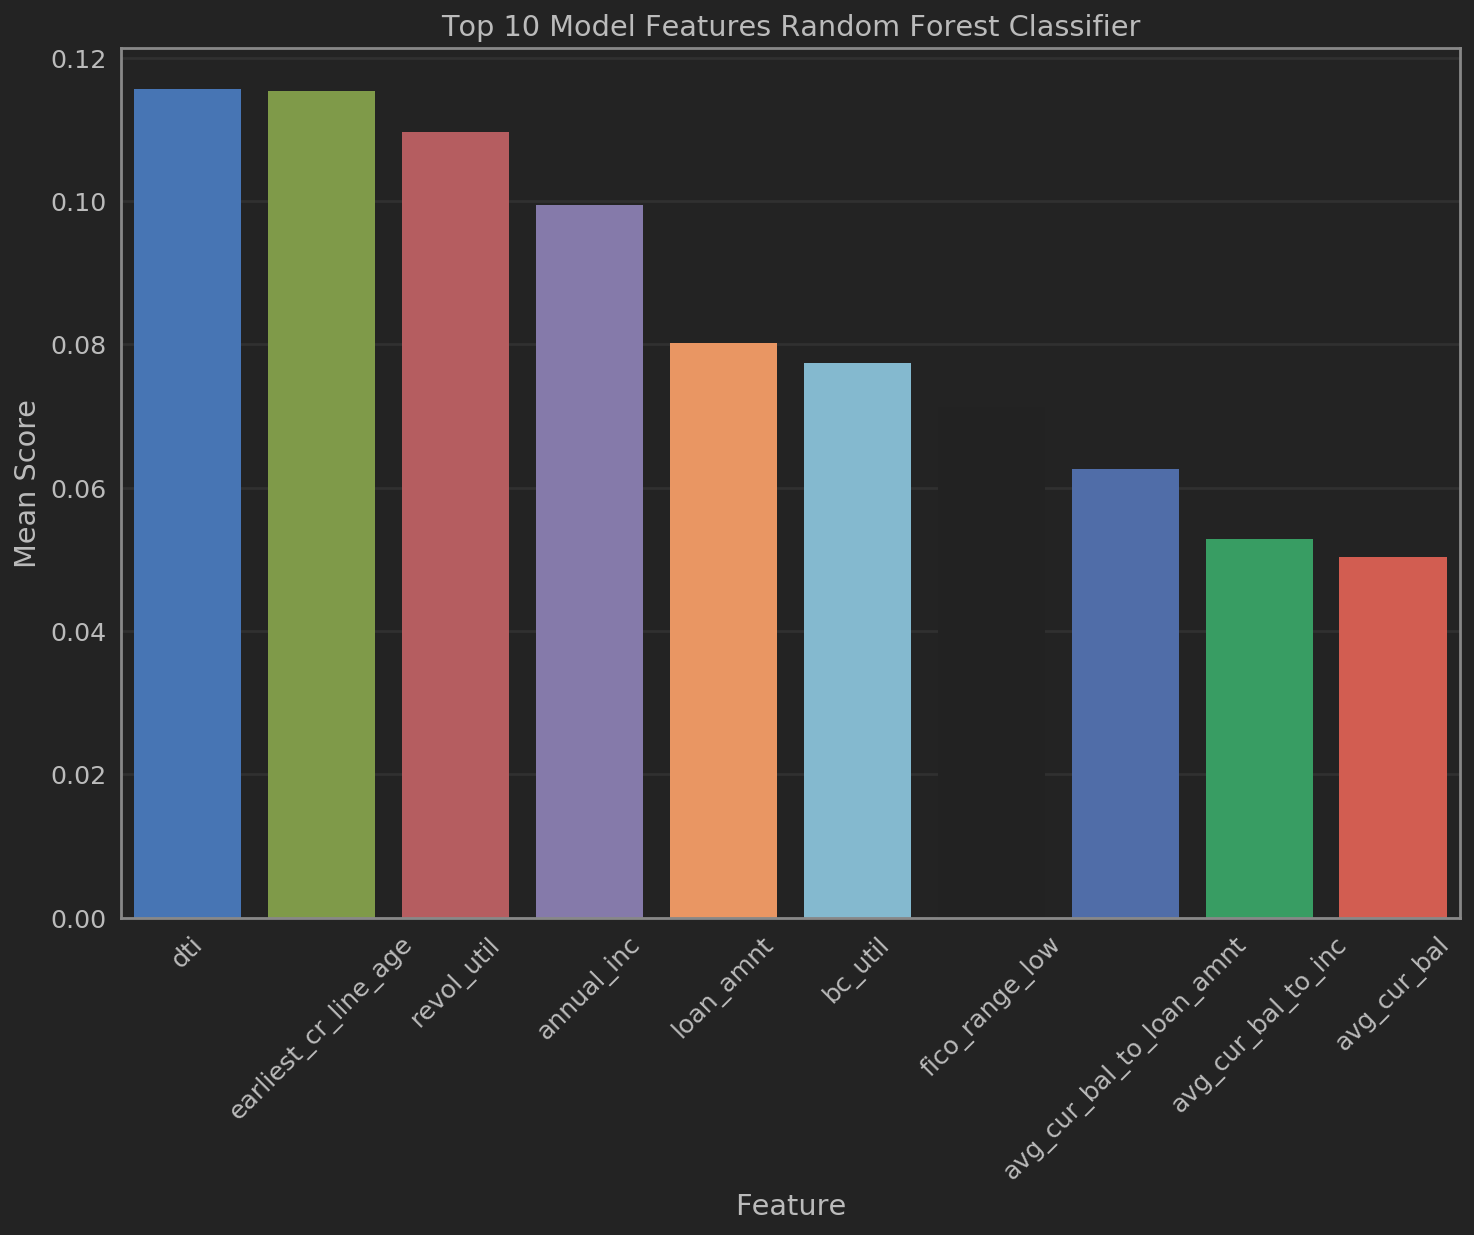

In [33]:
rf_top_features.plot_top_features(top_n=10)

## Model Selection

### Comparative Analysis

In [34]:
display(model_evals)

,FitTime,Accuracy,FBeta,F1,AUC
Decision Tree Classifier,2.0,0.785580,0.156742,0.154531,0.516244
Random Forest Classifier,2.0,0.874671,0.008998,0.014117,0.573608
Blagging Classifier (RF),2.0,0.719181,0.344518,0.270746,0.645877
Blagging Classifier (Extra Trees),20.0,0.749718,0.309224,0.259611,0.645899


### Optimal Model

In [35]:
blagging_base = ExtraTreesClassifier(criterion='entropy', 
                                     class_weight='balanced_subsample', 
                                     max_features=None, 
                                     n_estimators=60, random_state=11)

blagging_clf = BlaggingClassifier(base_estimator=blagging_base, 
                                  random_state=11, n_jobs=-1)

blagging_pipeline = Pipeline([('imp', Imputer(strategy='median')), 
                              ('clf', blagging_clf)])

model_pretty_name = 'Blagging Classifier (Extra Trees)'
blagging_model = LearningModel(model_pretty_name, blagging_pipeline)
blagging_model.fit_and_predict(**train_test_sets)

### Optimizing Hyperparameters

In [36]:
#ToDo: Perform GridSearch...

#### Results:

                                            |     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
                                            | :------------: | :-----------------: | :---------------: | :-------------: | 
                                            | Accuracy Score |      0.7899         |     0.7499        |        -        |
                                            | F1-score       |      0.1603         |     0.2602        |        -        |
                                            | AUC            |      0.5203         |     0.6463        |        -        |

# Conclusion *Pending